In [569]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

### 1. Load data and initial inspection

In [570]:
df = pd.read_csv(r"RUS_combined_data.csv")
df.head()   

,Unnamed: 0,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
0,0,35648046,TOYOTA,SEQUOIA,1/1/2020 0:03,А/д Бишкек - Торугарт. г. Кемин. 102 км.,Превышение установленной скорости движения на ...,3000
1,1,35648049,MITSUBISHI,COLT,1/1/2020 0:06,"А/д Бишкек - Аэропорт «Манас». АЗС Ак-Жол, 23 км",Превышение установленной скорости движения на ...,3000
2,2,35648071,HYUNDAI,ELANTRA,1/1/2020 0:20,"А/д Биш. Торугарт, 20км., с. Люксембург",Превышение установленной скорости движения на ...,3000
3,3,35648091,MERCEDES-BENZ,SPRINTER 311,1/1/2020 0:15,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000
4,4,35648093,MERCEDES-BENZ,E 240,1/1/2020 0:17,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,1000


In [571]:
if "Unnamed: 0" in df.columns:
    print('Дропнул эксель колонну, так как она не нужна жиги')
    df = df.drop(columns=["Unnamed: 0"])
df.info()

Дропнул эксель колонну, так как она не нужна жиги
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354392 entries, 0 to 2354391
Data columns (total 7 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   id                       int64 
 1   car_brand                object
 2   car_model                object
 3   violation_date           object
 4   crossroad_name           object
 5   violation_protocol_name  object
 6   violation_ammount        int64 
dtypes: int64(2), object(5)
memory usage: 125.7+ MB


In [572]:
df.isnull().sum()
df.shape

(2354392, 7)

In [573]:
df = df.dropna()
df.shape

(2354369, 7)

In [574]:
print('Чекаем являются ли эти колонки уникалными')
df.nunique()

Чекаем являются ли эти колонки уникалными


id                         1915019
car_brand                      242
car_model                     3194
violation_date             1978515
crossroad_name                 552
violation_protocol_name         20
violation_ammount                4
dtype: int64

In [575]:
if df["id"].is_unique:
    print("id уникален, всё ок")
else:
    print("id НЕ уникален, есть дубликаты")
total_rows = len(df)
unique_ids = df["id"].nunique()

print("Всего строк:", total_rows)
print("Уникальных id:", unique_ids)

id НЕ уникален, есть дубликаты
Всего строк: 2354369
Уникальных id: 1915019


In [576]:
dup_ids = df.loc[df["id"].duplicated(), "id"]
dup_ids.head()

256337    206208
256342     91231
256350     38233
256359     63396
256379    167667
Name: id, dtype: int64

In [577]:
print('Хочу выяснить сфигали они не уникальны')
print('Как будто тут один и тот же человек нарушает или машина')
df[df["id"] == 38233]

Хочу выяснить сфигали они не уникальны
Как будто тут один и тот же человек нарушает или машина


,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
256349,38233,HONDA,FIT,2019-03-04 01:16:21.000,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 20 км/ч,...",3000
256350,38233,HONDA,FIT,2019-03-04 01:18:20.000,А/д Бишкек - Торугарт 12.9км,"Нарушение «превышение скорости» свыше 20 км/ч,...",3000
282567,38233,HONDA,FIT,2019-03-21 03:34:27.000,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 20 км/ч,...",3000
328861,38233,HONDA,FIT,2019-04-19 08:08:53.000,г. Бишкек ул.Ж.Жолу д.291,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000


In [578]:
print('Количество строк где все колонны похожие:', df.duplicated().sum())
print('Дропаю только эти абсолютно похожие строки')
df.drop_duplicates(inplace=True)
print('Shape of df', df.shape)

Количество строк где все колонны похожие: 130725
Дропаю только эти абсолютно похожие строки
Shape of df (2223644, 7)


In [579]:
df.head()

,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
0,35648046,TOYOTA,SEQUOIA,1/1/2020 0:03,А/д Бишкек - Торугарт. г. Кемин. 102 км.,Превышение установленной скорости движения на ...,3000
1,35648049,MITSUBISHI,COLT,1/1/2020 0:06,"А/д Бишкек - Аэропорт «Манас». АЗС Ак-Жол, 23 км",Превышение установленной скорости движения на ...,3000
2,35648071,HYUNDAI,ELANTRA,1/1/2020 0:20,"А/д Биш. Торугарт, 20км., с. Люксембург",Превышение установленной скорости движения на ...,3000
3,35648091,MERCEDES-BENZ,SPRINTER 311,1/1/2020 0:15,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000
4,35648093,MERCEDES-BENZ,E 240,1/1/2020 0:17,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,1000


In [580]:
print('Видим что формат дат такая фигня')
df["violation_date"].astype(str).value_counts().sample(100)
    

Видим что формат дат такая фигня


violation_date
29/11/2019 19:32:17        1
11/1/2020 13:43            4
16/04/2020 12:33:49        1
24/11/2019 14:09:26        1
09/07/2020 12:55:53        1
                          ..
05/09/2019 12:51:43        1
29/03/2020 11:50:44        1
02/03/2021 17:38:57        1
2019-06-26 11:46:11.000    2
01/11/2020 09:15:22        1
Name: count, Length: 100, dtype: int64

In [581]:
df[df['violation_date'] == '51:00.0']

,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
1303318,149640,MERCEDES-BENZ,200E,51:00.0,"г. Бишкек, пересечение пр. Чуй - ул. И.Павлова",Невыполнение требований ПДД об остановке перед...,3000
1303646,156077,BMW,X6,51:00.0,г.Бишкек Путепровод по ул.Ибраимова,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1304679,12528,HONDA,FIT,51:00.0,"г.Бишкек, ул. Масалиева д. 49","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1312166,102797,MERCEDES-BENZ,SPRINTER 313,51:00.0,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,3000
1312904,190636,TOYOTA,IST,51:00.0,"г. Бишкек, пересечение пр. Жибек Жолу – ул. Ку...",Невыполнение требований дорожных знаков,3000
1313993,84931,AUDI,A6,51:00.0,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1314894,168554,NISSAN,CEFIRO,51:00.0,г.Бишкек Путепровод по ул. 7-Апреля,"Нарушение «превышение скорости» свыше 20 км/ч,...",3000
1317497,29600,NISSAN,PATROL,51:00.0,"г. Бишкек, путепровод по пр. Байтик Баатыра","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1321645,1303,TOYOTA,IST,51:00.0,"г. Бишкек, ж.м. Арча-Бешик ул. Садырбаева № 371/2","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1323153,205140,LEXUS,GX 470,51:00.0,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Фучика",Невыполнение требований ПДД об остановке перед...,3000


In [582]:
df[['raw_date', 'raw_time']] = (
    df['violation_date']
    .astype(str)
    .str.split(' ', n=1, expand=True)
)
print('raw_time is null', df['raw_time'].isnull().sum(), 'shape=', df.shape)
df.sample(50)

raw_time is null 134560 shape= (2223644, 9)


,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time
2281861,35607212,TOYOTA,RAV 4,24/12/2019 15:02:26,"г. Бишкек, пересечение пр. Ч.Айтматова - ул. И...",Нарушение требований разметки проезжей части д...,1000,24/12/2019,15:02:26
348104,133682,HONDA,CR-V,2019-04-29 14:50:33.000,"г. Бишкек, пересечение улиц Боконбаева - Абдр...",Невыполнение требований дорожных знаков,3000,2019-04-29,14:50:33.000
2329493,38395720,AUDI,100,19/12/2020 09:52:57,"г. Бишкек, ул. Л. Толстого № 36 К",Превышение установленной скорости движения на ...,1000,19/12/2020,09:52:57
1292215,37399413,TOYOTA,RAUM,29/07/2020 15:51:44,"Кеминский р-он. с. Ак-Бекет, основная а/д ""Биш...",Превышение установленной скорости движения на ...,5500,29/07/2020,15:51:44
1179577,204653,TOYOTA,ESTIMA,2019-07-26 13:05:55.000,"г. Бишкек, пересечение просп. Жибек-Жолу и бул...",Невыполнение требований дорожных знаков,3000,2019-07-26,13:05:55.000
840475,36895933,HYUNDAI,PORTER,30/05/2020 09:34:32,"г. Бишкек, пересечение улиц Л.Толстого - ул. Э...",Невыполнение требований дорожных знаков,1000,30/05/2020,09:34:32
749567,36671318,TOYOTA,IST,06/05/2020 18:35:29,"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж...",Невыполнение требований ПДД об остановке перед...,1000,06/05/2020,18:35:29
552324,36512699,MERCEDES-BENZ,SPRINTER 516,3/4/2020 17:49,"г. Бишкек, путепровод по пр. Манаса",Превышение установленной скорости движения на ...,1000,3/4/2020,17:49
345362,67195,MERCEDES-BENZ,SPRINTER 411,2019-04-28 11:46:02.000,А/д Бишкек - Торугарт. с. Чымкоргон. 78 км.,"Нарушение «превышение скорости» свыше 20 км/ч,...",3000,2019-04-28,11:46:02.000
1491519,37512856,VOLKSWAGEN,PASSAT,12/08/2020 16:56:39,г.Бишкек Путепровод по ул.Ибраимова,Превышение установленной скорости движения на ...,1000,12/08/2020,16:56:39


In [583]:
df.dropna(subset=['raw_time'], inplace=True)
df.shape

(2089084, 9)

In [584]:
df["raw_date"] = df["raw_date"].astype(str).str.strip()

In [585]:
s = df["raw_date"].astype(str).str.strip()

mask_dash = s.str.fullmatch(r"\d{4}-\d{2}-\d{2}")

mask_slash = s.str.fullmatch(r"\d{1,2}/\d{1,2}/\d{4}")

norm_dt = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")

norm_dt[mask_dash] = pd.to_datetime(
    s[mask_dash],
    format="%Y-%m-%d",
    errors="coerce"
)

norm_dt[mask_slash] = pd.to_datetime(
    s[mask_slash],
    format="%d/%m/%Y",
    errors="coerce"
)

df["normalized_date"] = norm_dt

print("Всего строк:", len(df))
print("Не распарсилось:", df["normalized_date"].isna().sum())
df[["raw_date", "normalized_date"]].sample(200)


Всего строк: 2089084
Не распарсилось: 0


,raw_date,normalized_date
732600,2019-05-30,2019-05-30
31543,14/01/2020,2020-01-14
2339479,24/12/2020,2020-12-24
390477,10/03/2020,2020-03-10
384734,11/03/2020,2020-03-11
...,...,...
25422,11/1/2020,2020-01-11
2271117,20/12/2019,2019-12-20
368873,01/03/2020,2020-03-01
180026,01/02/2020,2020-02-01


In [586]:
df['normalized_time'] = pd.to_datetime(df['raw_time'], errors='coerce').dt.time

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14672\2202367266.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['normalized_time'] = pd.to_datetime(df['raw_time'], errors='coerce').dt.time


In [587]:
print(df.shape)
df.sample(100)

(2089084, 11)


,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time,normalized_date,normalized_time
646769,38954149,TOYOTA,PRIUS,19/04/2021 12:13:55,"Кеминский р-он. с. Ак-Бекет, основная а/д ""Биш...",Превышение установленной скорости движения на ...,5500,19/04/2021,12:13:55,2021-04-19,12:13:55
1510549,37546050,HONDA,FIT,16/08/2020 20:39:22,"г. Бишкек, пересечение улиц М.Горького – Ч.Айт...",Невыполнение требований ПДД об остановке перед...,1000,16/08/2020,20:39:22,2020-08-16,20:39:22
2184203,38239673,TOYOTA,ESTIMA,13/11/2020 10:07:00,А/д Бишкек – Ош. 149км.,Превышение установленной скорости движения на ...,3000,13/11/2020,10:07:00,2020-11-13,10:07:00
2156656,38188060,HONDA,ODYSSEY,05/11/2020 10:29:11,г.Бишкек Путепровод по ул.Ибраимова,Превышение установленной скорости движения на ...,1000,05/11/2020,10:29:11,2020-11-05,10:29:11
2220245,38313049,TOYOTA,SEQUOIA,28/11/2020 06:00:29,"г. Бишкек, пересечение улиц М.Горького – Ч.Айт...",Нарушение правил обгона или маневрирования с в...,5500,28/11/2020,06:00:29,2020-11-28,06:00:29
...,...,...,...,...,...,...,...,...,...,...,...
2314709,38364831,LEXUS,GX 470,11/12/2020 23:16:15,Основная автодорога Бишкек - Торугарт 12.9км,Превышение установленной скорости движения на ...,1000,11/12/2020,23:16:15,2020-12-11,23:16:15
1253560,37324897,MERCEDES-BENZ,210,17/07/2020 15:35:44,"г. Бишкек, пересечение улиц Л.Толстого - ул. Э...",Нарушение требований разметки проезжей части д...,1000,17/07/2020,15:35:44,2020-07-17,15:35:44
2293530,38321106,RAVON,R3,01/12/2020 01:22:20,"г.Бишкек, Путепровод по ул.Шабдан-Баатыра (ул....",Превышение установленной скорости движения на ...,1000,01/12/2020,01:22:20,2020-12-01,01:22:20
993065,37034092,HONDA,ODYSSEY,10/06/2020 15:29:20,г. Бишкек ул. Жибек-Жолу № 291.,Превышение установленной скорости движения на ...,1000,10/06/2020,15:29:20,2020-06-10,15:29:20


In [588]:
df["year"] = df["normalized_date"].dt.year
df["month"] = df["normalized_date"].dt.month
df["day"] = df["normalized_date"].dt.day
df["hour"] = pd.to_datetime(df["raw_time"], errors="coerce").dt.hour
df["weekday"] = df["normalized_date"].dt.dayofweek
weekday_map = {
    0: "Mon", 1: "Tue", 2: "Wed", 
    3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"
}
print('По дням недели распределил, dayofweek офигенная функция')
df["weekday_name"] = df["weekday"].map(weekday_map)
df.drop(columns=['violation_date'], inplace=True)
df.sample(10)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14672\4196713491.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hour"] = pd.to_datetime(df["raw_time"], errors="coerce").dt.hour


По дням недели распределил, dayofweek офигенная функция


,id,car_brand,car_model,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time,normalized_date,normalized_time,year,month,day,hour,weekday,weekday_name
2122470,35407212,HONDA,ACCORD,г.Бишкек Путепровод по ул.Ибраимова,Превышение установленной скорости движения на ...,1000,21/11/2019,22:16:21,2019-11-21,22:16:21,2019,11,21,22,3,Thu
138720,35878421,HYUNDAI,SONATA,"г. Бишкек, пересечение пр. Ч.Айтматова - ул. И...",Невыполнение требований дорожных знаков,1000,09/02/2020,04:14:28,2020-02-09,04:14:28,2020,2,9,4,6,Sun
16429,35680376,MERCEDES-BENZ,S 500,"г. Бишкек, пересечение ул. Байтик Баатыра - ул...",Невыполнение требований дорожных знаков,1000,7/1/2020,18:54,2020-01-07,18:54:00,2020,1,7,18,1,Tue
1150803,170012,TOYOTA,COROLLA VERSO,г.Бишкек Путепровод по ул. 7-Апреля,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000,2019-07-20,09:18:42.000,2019-07-20,09:18:42,2019,7,20,9,5,Sat
570075,36556486,BMW,X5,"г. Бишкек, пересечение ул. Байтик Баатыра - ул...",Невыполнение требований дорожных знаков,1000,14/04/2020,13:15:54,2020-04-14,13:15:54,2020,4,14,13,1,Tue
1523764,37571709,TOYOTA,IST,"г. Бишкек, пересечение пр. Шабдан Баатыра - ул...",Невыполнение требований дорожных знаков,1000,19/08/2020,14:29:19,2020-08-19,14:29:19,2020,8,19,14,2,Wed
1618482,34772349,TOYOTA,VOXY,"Московский р-он, с. Мураке ул. С. Бегалиева № 7",Превышение установленной скорости движения на ...,3000,09/09/2019,14:42:53,2019-09-09,14:42:53,2019,9,9,14,0,Mon
1601082,34718967,MAZDA,6,"г. Бишкек, пересечение улиц Ахунбаева - Тыналиева","Проезд на запрещенный сигнал светофора, либо ж...",3000,06/09/2019,11:30:14,2019-09-06,11:30:14,2019,9,6,11,4,Fri
1671530,34890877,MERCEDES-BENZ,S 500,А/д Бишкек - Торугарт. с. Жаны-Алыш. 95 км.,Превышение установленной скорости движения на ...,1000,22/09/2019,17:37:42,2019-09-22,17:37:42,2019,9,22,17,6,Sun
2282382,35610122,ВАЗ,21074,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000,27/12/2019,09:28:38,2019-12-27,09:28:38,2019,12,27,9,4,Fri


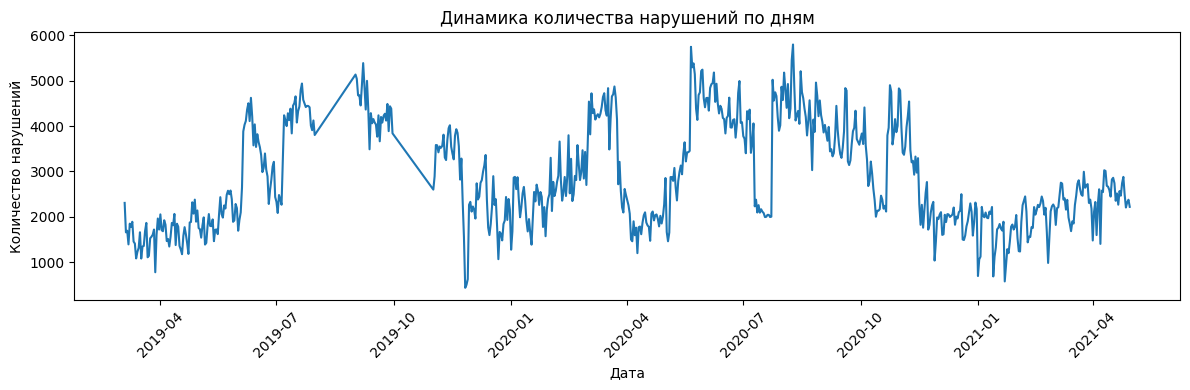

In [589]:
daily_counts = (
    df
    .groupby('normalized_date')   
    .size()                      
    .reset_index(name='n_violations')  
)
plt.figure(figsize=(12, 4))

plt.plot(
    daily_counts['normalized_date'],
    daily_counts['n_violations']
)

plt.xlabel('Дата')
plt.ylabel('Количество нарушений')
plt.title('Динамика количества нарушений по дням')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

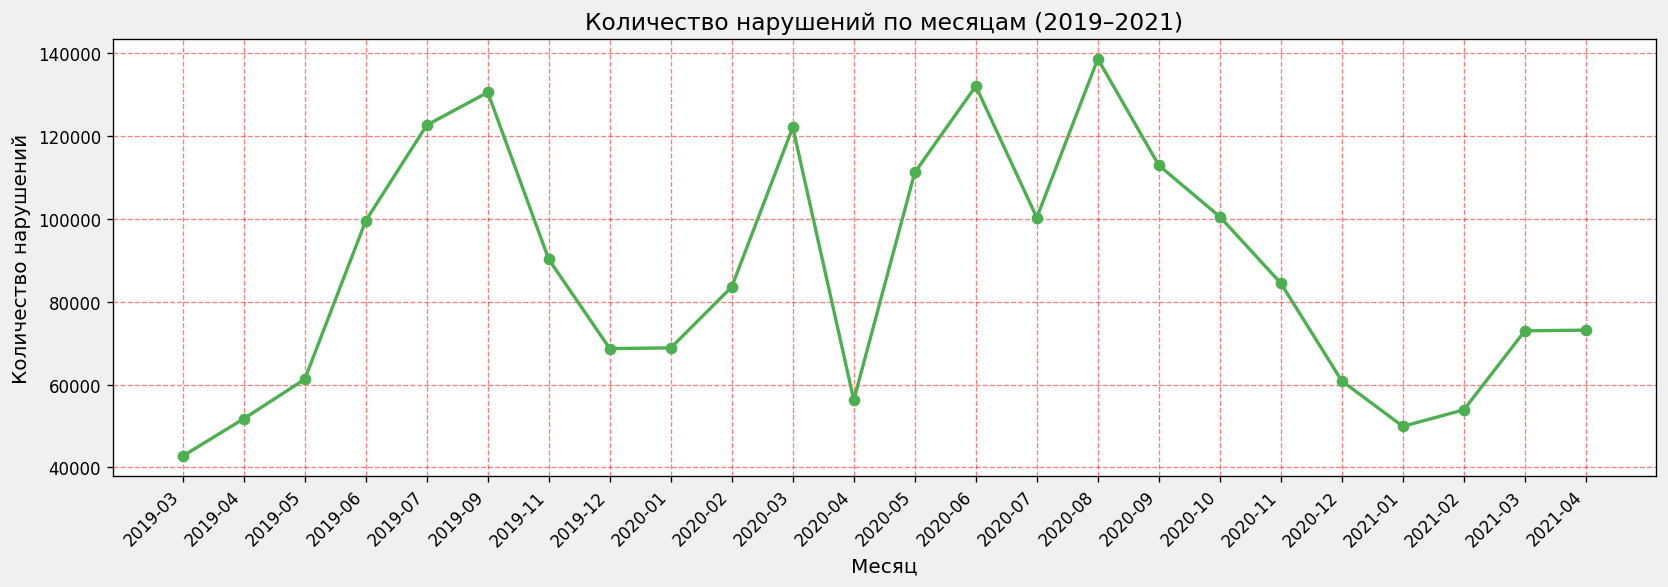

In [590]:
monthly_counts = (
    df
    .groupby(['year', 'month'])
    .size()
    .reset_index(name='n_violations')
    .sort_values(['year', 'month'])
)
monthly_counts['year_month'] = (
    monthly_counts['year'].astype(str)
    + '-'
    + monthly_counts['month'].astype(str).str.zfill(2)  
)

x = range(len(monthly_counts))
y = monthly_counts['n_violations']

fig, ax = plt.subplots(figsize=(14, 5), dpi=120)

fig.patch.set_facecolor('#f0f0f0')

ax.plot(
    x,
    y,
    marker='o',
    linewidth=2,
    color='#4caf50'                 
)

ax.grid(True, linestyle='--', alpha=0.4)

ax.set_xlabel('Месяц', fontsize=12)
ax.set_ylabel('Количество нарушений', fontsize=12)
ax.set_title('Количество нарушений по месяцам (2019–2021)', fontsize=14)

step = max(1, len(monthly_counts) // 20)

ax.set_xticks(x[::step])
ax.set_xticklabels(
    monthly_counts['year_month'].iloc[::step],
    rotation=45,
    ha='right'
)
ax.grid(True, linestyle='--', color='red', alpha=0.5)
plt.tight_layout()
plt.show()

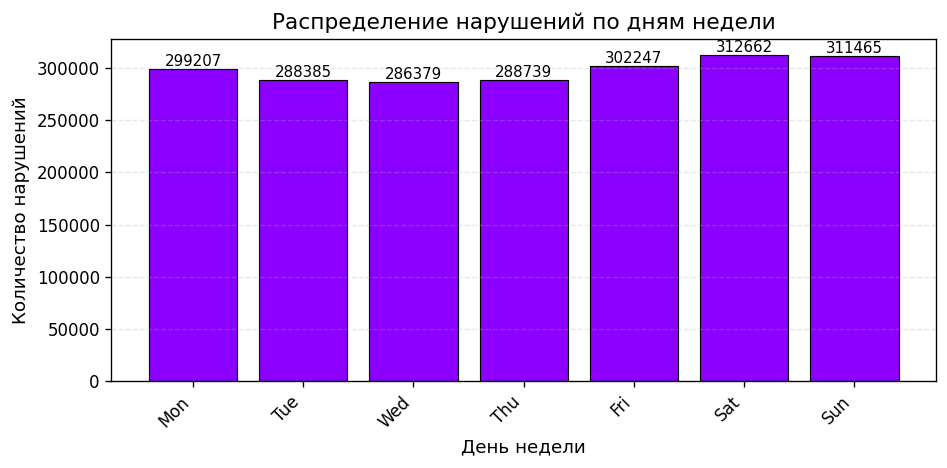

In [591]:
weekday_counts = (
    df
    .groupby(['weekday_name'])
    .size()
    .reset_index(name='n_violations')
    .sort_values('weekday_name')
)
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

weekday_counts['weekday_name'] = pd.Categorical(
    weekday_counts['weekday_name'],
    categories=order,
    ordered=True
)

weekday_counts = weekday_counts.sort_values('weekday_name')
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
bars = ax.bar(
    weekday_counts['weekday_name'],
    weekday_counts['n_violations'],
    color='#8B00FF',      
    edgecolor='black',    
    linewidth=0.7
)

ax.set_xlabel('День недели', fontsize=11)
ax.set_ylabel('Количество нарушений', fontsize=11)
ax.set_title('Распределение нарушений по дням недели', fontsize=13)

plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height,                             
        f'{int(height)}',                   
        ha='center', va='bottom',          
        fontsize=9
    )

ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


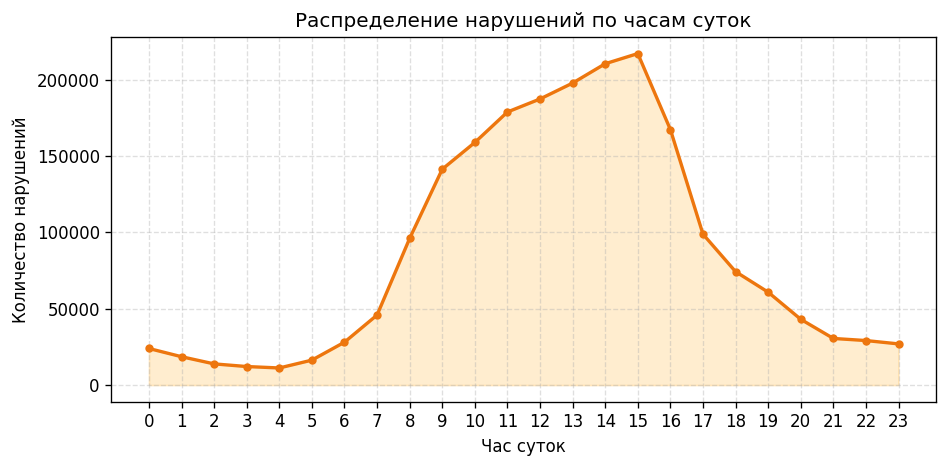

In [592]:
hour_counts = (
    df
    .groupby('hour')
    .size()
    .reset_index(name='n_violations')
    .sort_values('hour')
)

plt.figure(figsize=(8, 4), dpi=120)

x = hour_counts['hour']
y = hour_counts['n_violations']

plt.plot(x, y, marker='o', linewidth=2, color='#ED760E', markersize=4)

plt.fill_between(
    x,
    y,
    alpha=0.25,        
    color='#FFB841'    
)

plt.xlabel('Час суток')
plt.ylabel('Количество нарушений')
plt.title('Распределение нарушений по часам суток')

plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

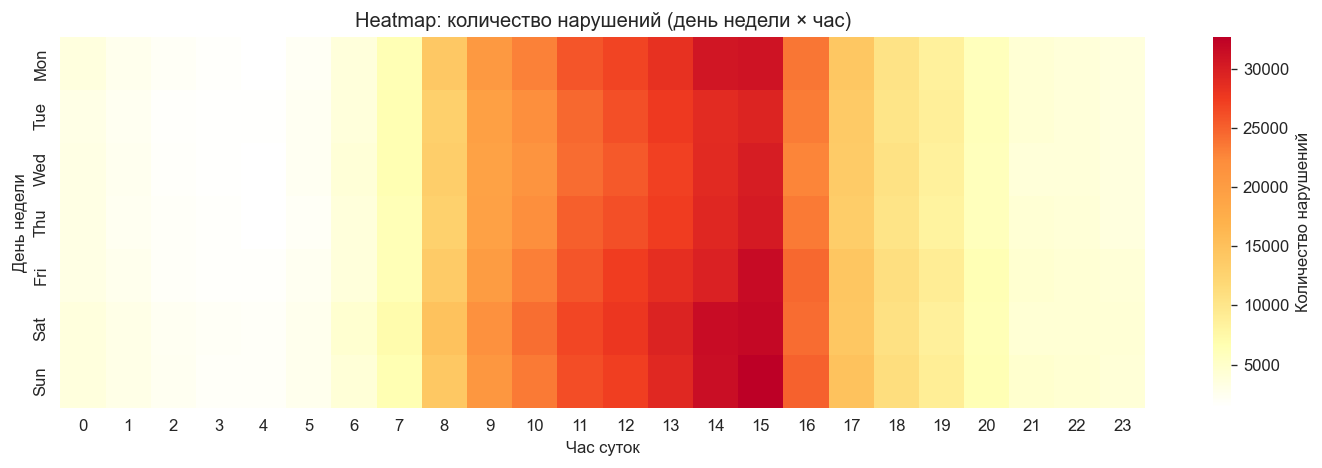

In [597]:


pivot = (
    df
    .groupby(['weekday', 'hour'])
    .size()
    .reset_index(name='n_violations')
    .pivot(index='weekday', columns='hour', values='n_violations')
    .fillna(0)
)

colors = [
    '#ffffff',
    '#ffffb2',
    '#fed976',
    '#feb24c',
    '#fd8d3c',
    '#f03b20',
    '#bd0026'
]
custom_cmap = LinearSegmentedColormap.from_list(
    'white_yellow_orange_red',
    colors
)

weekday_labels = (
    df[['weekday', 'weekday_name']]
    .drop_duplicates()
    .sort_values('weekday')['weekday_name']
    .tolist()
)

pivot_sns = pivot.copy()
pivot_sns.index = weekday_labels  

plt.figure(figsize=(12, 4), dpi=120)

sns.heatmap(
    pivot_sns,
    cmap=custom_cmap,
    cbar_kws={'label': 'Количество нарушений'} 
)

plt.xlabel('Час суток')
plt.ylabel('День недели')
plt.title('Heatmap: количество нарушений (день недели × час)')

plt.xticks(
    ticks=np.arange(0.5, 24.5),      
    labels=np.arange(0, 24)          
)

plt.tight_layout()
plt.show()


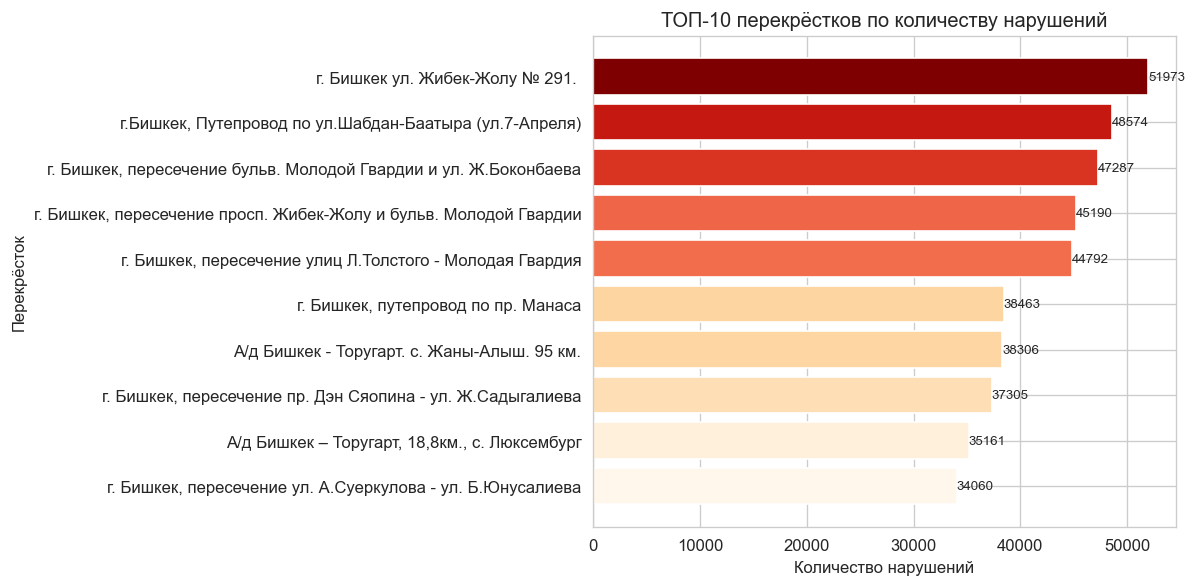

In [602]:
import matplotlib.colors as mcolors

top_crossroads = (
    df['crossroad_name']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  
)

values = top_crossroads.values

norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())

cmap = plt.cm.OrRd

colors = cmap(norm(values))

plt.figure(figsize=(10, 5), dpi=120)

plt.barh(top_crossroads.index, top_crossroads.values, color=colors)

plt.xlabel('Количество нарушений')
plt.ylabel('Перекрёсток')
plt.title('ТОП-10 перекрёстков по количеству нарушений')

for i, v in enumerate(top_crossroads.values):
    plt.text(v, i, str(v), va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()


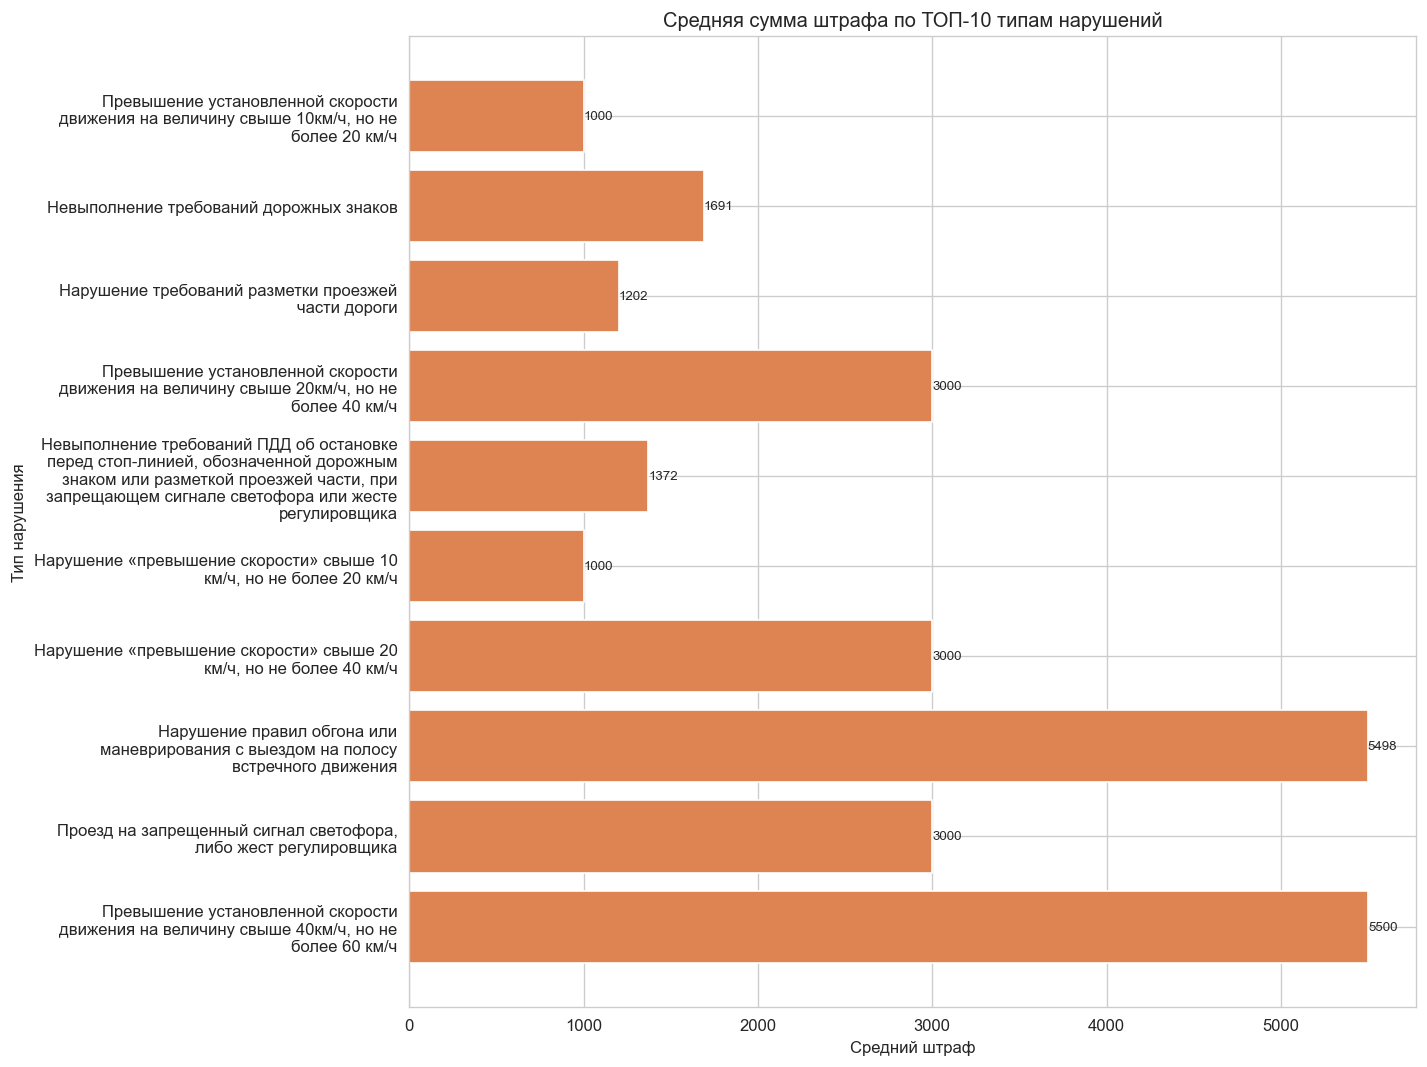

In [614]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

top_protos_counts = (
    df['violation_protocol_name']
    .value_counts()
    .head(10)                      
    .sort_values(ascending=True)    
)

top_proto_names = top_protos_counts.index 

proto_mean_fine = (
    df[df['violation_protocol_name'].isin(top_proto_names)]
    .groupby('violation_protocol_name')['violation_ammount']
    .mean()
    .loc[top_proto_names]     
)

wrapped_labels = [textwrap.fill(name, 40) for name in proto_mean_fine.index]

plt.figure(figsize=(12, 9), dpi=120)

y_pos = np.arange(len(proto_mean_fine))

plt.barh(y_pos, proto_mean_fine.values, color='#dd8452')

plt.xlabel('Средний штраф')
plt.ylabel('Тип нарушения')
plt.title('Средняя сумма штрафа по ТОП-10 типам нарушений')

plt.yticks(y_pos, wrapped_labels)

for i, v in enumerate(proto_mean_fine.values):
    plt.text(v, i, f'{v:.0f}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()